In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import hmac
import hashlib
from urllib.parse import urlencode
from datetime import datetime

In [2]:


BASE_URL = "https://api.binance.com"

def get_btc_price():
    url = f"{BASE_URL}/api/v3/ticker/price?symbol=BTCUSDT"
    res = requests.get(url)
    return res.json()

# Create empty lists to store data
timestamps = []
prices = []

# Collect data for 1 minute (60 seconds)
print("Collecting BTC price data for 1 minute...")
for i in range(60):
    btc_data = get_btc_price()
    price = float(btc_data['price'])
    timestamps.append(datetime.now())
    prices.append(price)
    print(f"BTC Price: ${price}")
    time.sleep(1)

# Create DataFrame and save to CSV
df = pd.DataFrame({'timestamp': timestamps, 'price': prices})
df.to_csv('btc_prices.csv', index=False)




BTC Price: $110014.25
BTC Price: $110014.25
BTC Price: $110014.24
BTC Price: $110014.25
BTC Price: $110014.98
BTC Price: $110029.98
BTC Price: $110029.99
BTC Price: $110029.99
BTC Price: $110029.98
BTC Price: $110035.31
BTC Price: $110046.61
BTC Price: $110049.04
BTC Price: $110049.03
BTC Price: $110049.82
BTC Price: $110057.01
BTC Price: $110057.02
BTC Price: $110057.02
BTC Price: $110057.02
BTC Price: $110059.47
BTC Price: $110059.47
BTC Price: $110064.74
BTC Price: $110075.99
BTC Price: $110080.0
BTC Price: $110080.0
BTC Price: $110080.0
BTC Price: $110079.99
BTC Price: $110079.99
BTC Price: $110080.0
BTC Price: $110080.0
BTC Price: $110088.76
BTC Price: $110088.77
BTC Price: $110088.77
BTC Price: $110088.76
BTC Price: $110090.97
BTC Price: $110090.99
BTC Price: $110090.99
BTC Price: $110090.99
BTC Price: $110090.98
BTC Price: $110090.98
BTC Price: $110090.98
BTC Price: $110090.98
BTC Price: $110090.99
BTC Price: $110090.99
BTC Price: $110090.98
BTC Price: $110090.99
BTC Price: $110

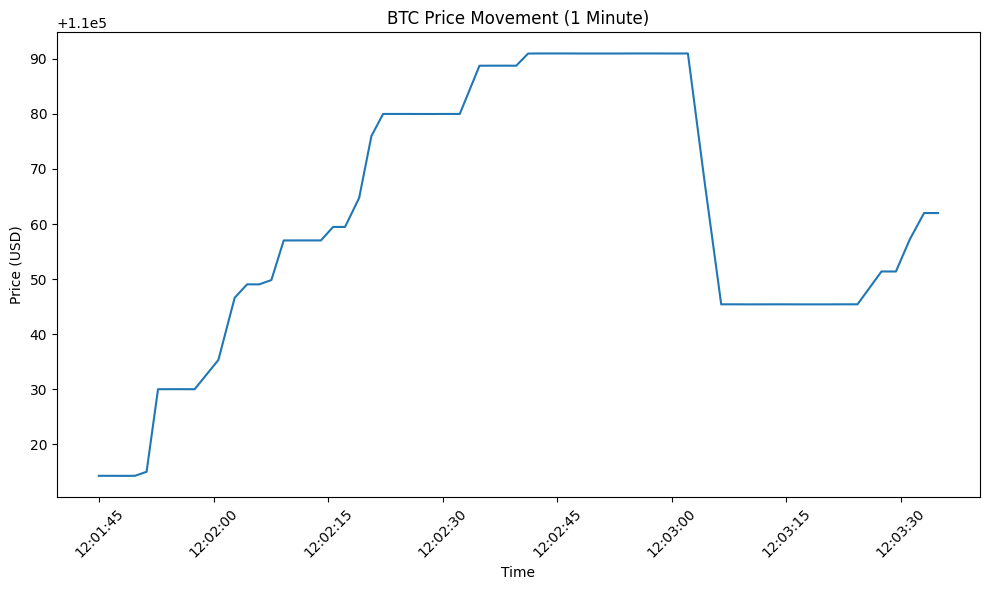

In [3]:
# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['price'])
plt.title('BTC Price Movement (1 Minute)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

# === API keys ===
API_KEY = ""
API_SECRET = ""

BASE_URL = "https://api.binance.com"


In [5]:
def signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload)
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, int(time.time()*1000))
    else:
        query_string = "timestamp={}".format(int(time.time()*1000))

    # Create signature
    signature = hmac.new(API_SECRET.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()
    query_string += "&signature={}".format(signature)

    url = BASE_URL + url_path + '?' + query_string
    headers = {"X-MBX-APIKEY": API_KEY}
    if http_method == "GET":
        return requests.get(url, headers=headers).json()
    else:
        raise ValueError("Only GET implemented")




In [6]:
# === Get Historical Kline Data ===
def get_historical_klines(symbol="BTCUSDT", interval="1d", start_str="5 years ago UTC"):
    url = BASE_URL + "/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": 1000,
        "startTime": int(pd.Timestamp(start_str).timestamp()*1000)
    }
    
    all_data = []
    while True:
        res = requests.get(url, params=params).json()
        if not res:
            break
        all_data.extend(res)
        last_time = res[-1][0]
        params["startTime"] = last_time + 1
        if len(res) < 1000:
            break
        time.sleep(0.5)  # avoid rate limits
    return all_data


In [8]:
# === Fetch BTC/USDT last 5 years daily data ===
print("Fetching BTC/USDT historical data...")
five_years_ago = (datetime.now() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')
data = get_historical_klines("BTCUSDT", "1d", five_years_ago)

# Convert to DataFrame
df = pd.DataFrame(data, columns=[
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "qav", "num_trades", "taker_base_vol", "taker_quote_vol", "ignore"
])
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')

# Keep only useful columns
df = df[["open_time", "open", "high", "low", "close", "volume"]]
df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

# Save to CSV
df.to_csv("btc_usdt_5y.csv", index=False)
print("Saved 5 years BTC/USDT data to btc_usdt_5y.csv")

Fetching BTC/USDT historical data...
Saved 5 years BTC/USDT data to btc_usdt_5y.csv


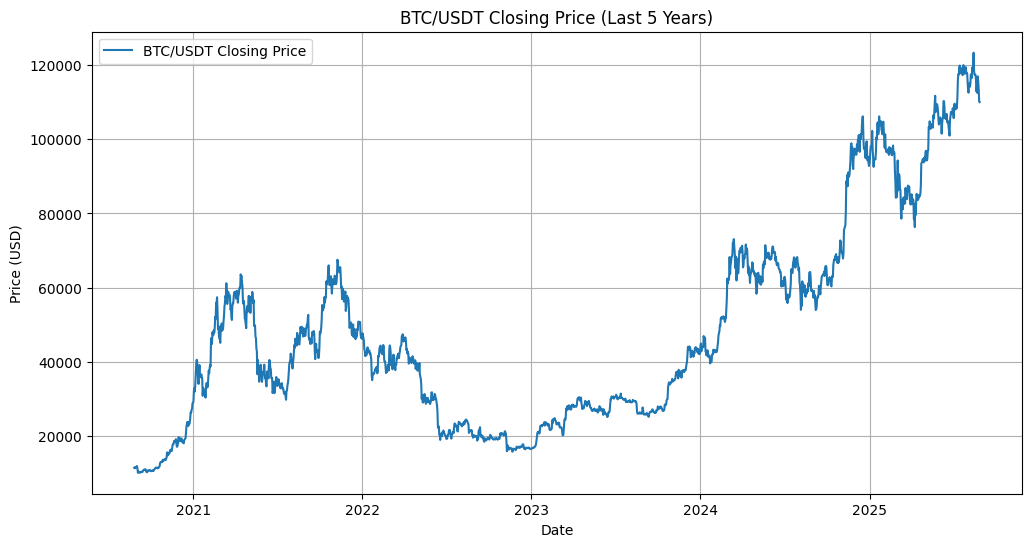

In [10]:
# === Visualization ===
plt.figure(figsize=(12,6))
plt.plot(df["open_time"], df["close"], label="BTC/USDT Closing Price")
plt.title("BTC/USDT Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

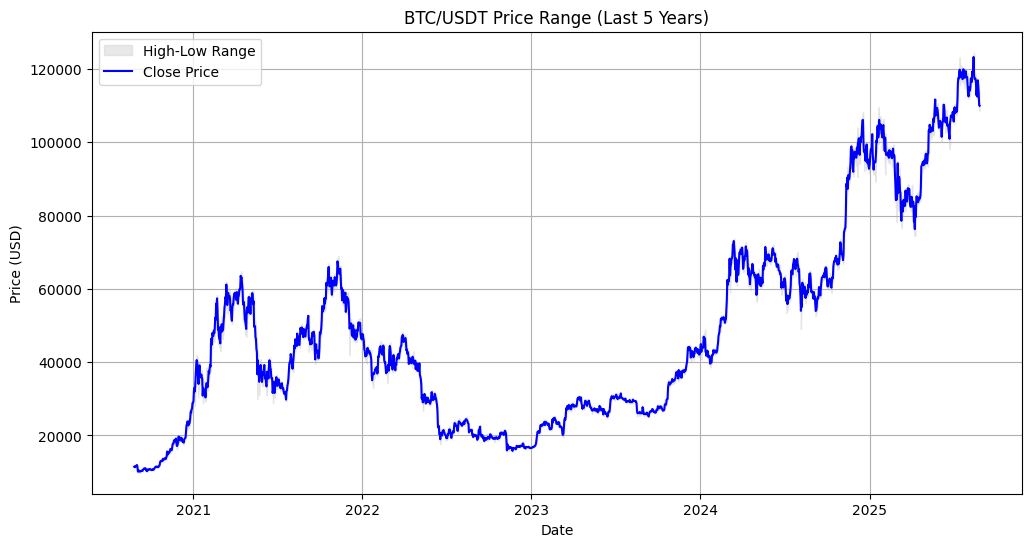

In [11]:
# Candlestick-style High-Low visualization
plt.figure(figsize=(12,6))
plt.fill_between(df["open_time"], df["low"], df["high"], color="lightgray", alpha=0.5, label="High-Low Range")
plt.plot(df["open_time"], df["close"], color="blue", label="Close Price")
plt.title("BTC/USDT Price Range (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

d:\WORKSPACE\COMPITITION\DataQuest\venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


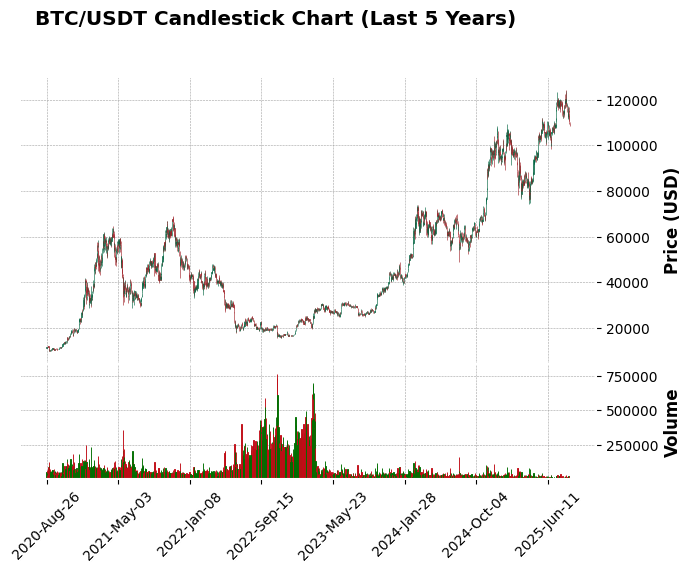

<Figure size 640x480 with 0 Axes>

In [13]:
import mplfinance as mpf

# Prepare DataFrame for mplfinance
df_mpf = df.set_index('open_time')[['open', 'high', 'low', 'close', 'volume']]

# Plot candlestick chart
mpf.plot(df_mpf, type='candle', style='charles', volume=True, title='BTC/USDT Candlestick Chart (Last 5 Years)', ylabel='Price (USD)')
plt.tight_layout()